# Regional Relative Sea Level Rise data
This notebook extracts RSLR data through the following steps:
* extract RSLR rates from raw NetCDF files
* merge RSLR data with mangrove centroids
* implement 3 intensity categories
* plot


In [15]:
import xarray as xr
from pathlib import Path
import pandas as pd
import geopandas as gpd
from shapely.geometry import box
import numpy as np

import copy
import pandas as pd
import seaborn as sns
import cartopy.crs as ccrs
import cartopy as ctp
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

In [16]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in intersection")
warnings.filterwarnings("ignore", message="invalid value encountered in buffer")

In [2]:
# Define data paths
data_dir = Path("../../data/intermediate/")
raw_data_dir = Path(f"../../data/raw/hazard/Garner_RSLR/ar6-regional-confidence/regional/confidence_output_files/medium_confidence/")
ssps = [245, 370, 585]

In [4]:
file_name = f'total_ssp245_medium_confidence_rates.nc'
dataset = xr.open_dataset(raw_data_dir.joinpath(f'ssp245', file_name))
dataset

<xarray.Dataset> Size: 397MB
Dimensions:                (locations: 66190, years: 14, quantiles: 107)
Coordinates:
  * locations              (locations) int32 265kB 1 2 ... 1018003580 1018003590
  * years                  (years) int32 56B 2020 2030 2040 ... 2130 2140 2150
  * quantiles              (quantiles) float64 856B 0.0 0.001 ... 0.999 1.0
Data variables:
    lat                    (locations) float32 265kB ...
    lon                    (locations) float32 265kB ...
    sea_level_change_rate  (quantiles, years, locations) float32 397MB ...
Attributes:
    description:  Combined confidence output file for AR6 sea-level change pr...
    history:      Created Wed Jul 14 14:08:01 2021
    source:       Files Combined: /projects/kopp/ar6/regional/pboxes_rates/pb...

## Extract regional RSLR rates from NetCDFs

In [5]:
# new version
# extract median rates of regional relative sea level rise until 2100
df = pd.DataFrame()
start_year = 2020
end_year = 2100

for ssp in ssps:
    file_name = f'total_ssp{ssp}_medium_confidence_rates.nc'
    dataset = xr.open_dataset(raw_data_dir.joinpath(f'ssp{ssp}', file_name))

    # extract sea level change rates variable
    sea_level_change = dataset['sea_level_change_rate']

    # fix quantile dimension at median
    sea_level_change_at_0_5 = sea_level_change.sel(quantiles=0.5)

    # slice years 2020 - 2100
    sea_level_change_filtered = sea_level_change_at_0_5.sel(years=slice(start_year, end_year))

    # calculate the median across the filtered years
    median_values = sea_level_change_filtered.median(dim='years')

    # values to dataframe
    df[f'median_rslr_{ssp}'] = median_values.values

    dataset.close()

# add location, latitude, and longitude information to the DataFrame
df['location'] = median_values['locations'].values
df['latitude'] = dataset['lat'].sel(locations=median_values['locations']).values
df['longitude'] = dataset['lon'].sel(locations=median_values['locations']).values

# Save the DataFrame to a CSV file
df.to_csv(data_dir.joinpath('hazard', 'RSLR', 'rslr_all_ssps_locations_2020-2100.csv'), index=False)

## Match regional RSLR data with mangrove extents

In [12]:
# new
source = 'Bunting'
# read rslr data and convert to geodataframe
df = pd.read_csv(data_dir.joinpath('hazard', 'RSLR', 'rslr_all_ssps_locations.csv'))
gdf = gpd.GeoDataFrame(data=df, geometry=gpd.points_from_xy(df["longitude"], df["latitude"]), crs="EPSG:4326")
gdf = gdf.drop(columns=['latitude', 'longitude', 'location'])

# load ecosystem data
exp = pd.read_csv(data_dir.joinpath('mangroves', f'{source}_mangroves_2020_global.csv'))
exp_gdf = gpd.GeoDataFrame(data=exp, geometry=gpd.points_from_xy(exp["longitude"], exp["latitude"]), crs="EPSG:4326")
exp_bounds = exp_gdf.total_bounds

# clip rslr data to ecosystem bounds
bounds_buffered = box(*exp_bounds).buffer(2) # add 2 degree buffer to the bounds
buffered_gdf = gpd.GeoDataFrame(geometry=[bounds_buffered], crs=exp_gdf.crs)
gdf_clip = gpd.clip(gdf, buffered_gdf)

# reproject to equal area (Eckert IV)
proj_eck4 = '+proj=eck4 +lon_0=0 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs'  # Eckert IV projection
gdf_clip = gdf_clip.to_crs(proj_eck4)
exp_gdf = exp_gdf.to_crs(proj_eck4)

# match points
join = gpd.sjoin_nearest(exp_gdf, gdf_clip, distance_col="rslr_distance")
join = join.drop(columns=['index_right'])

# reproject
join = join.to_crs("EPSG:4326")
join = join.drop_duplicates(keep='first')

# sort into intensity categories
categories = [(0, 4), (4, 7), (7, np.inf)]

for ssp in ssps:
    for i, category in enumerate(categories):
        lower_bound, upper_bound = category
        cat = i+1
        label = f'RSLR{cat}_ssp{ssp}'
        join[label] = np.where(
            (join[f'median_rslr_{ssp}'] >= lower_bound) & (join[f'median_rslr_{ssp}'] < upper_bound),
            1,
            0
        )

    # adjust categories to make them exclusive (always prioritize highest possible)
    join[f'RSLR2_ssp{ssp}'] = join[f'RSLR2_ssp{ssp}'] & ~join[f'RSLR3_ssp{ssp}']
    join[f'RSLR1_ssp{ssp}'] = join[f'RSLR1_ssp{ssp}'] & ~(join[f'RSLR2_ssp{ssp}'] | join[f'RSLR3_ssp{ssp}'])

join.to_csv(data_dir.joinpath('mangroves', f'{source}_mangroves_2020_global_rslr_all_ssps_2020-2100.csv'), index=False)

## Plot regional RSLR for all SSPs

/Users/shuelsen/miniforge3/envs/climada_env/lib/python3.9/site-packages/shapely/predicates.py:688: RuntimeWarning: invalid value encountered in covers
  return lib.covers(a, b, **kwargs)


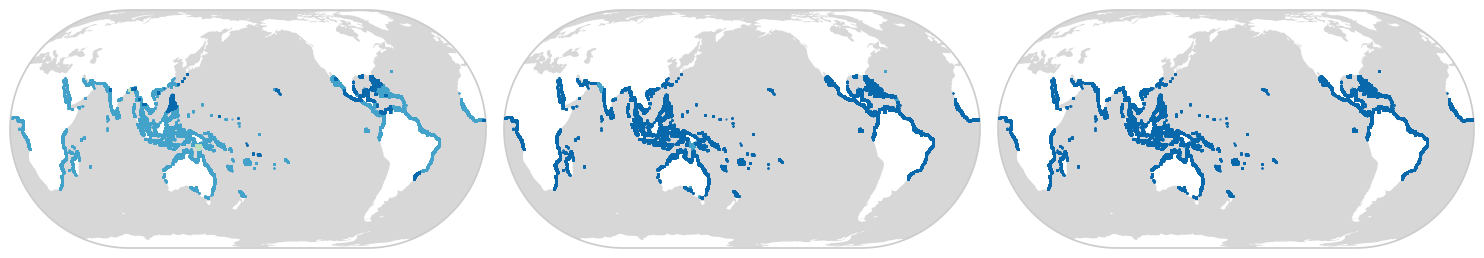

In [17]:
df = pd.read_csv(data_dir.joinpath('mangroves', 'Bunting_mangroves_2020_global_rslr_all_ssps_2020-2100.csv'))
sns.set(style="whitegrid")

fig, axs = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': ccrs.EckertIV(central_longitude=180)})

for i, ssp in enumerate(ssps):
    ax = axs[i]
    ax.add_feature(cfeature.OCEAN, facecolor='#D7D7D7')
    extent = ax.get_extent(crs=ccrs.EckertIV(central_longitude=180))
    x1, x2, y1, y2 = extent
    ax.set_ylim([y1, y2])
    
    # Plot points below 4mm/year
    ind_1 = df[f'RSLR1_ssp{ssp}'] == 1
    lon_1 = df.loc[ind_1, 'longitude']
    lat_1 = df.loc[ind_1, 'latitude']
    scatter1 = ax.scatter(lon_1, lat_1, c='#bae4bc', s=0.25, transform=ccrs.PlateCarree(), zorder=2)
    # Plot points 4-7mm/year
    ind_2 = df[f'RSLR2_ssp{ssp}'] == 1
    lon_2 = df.loc[ind_2, 'longitude']
    lat_2 = df.loc[ind_2, 'latitude']
    scatter2 = ax.scatter(lon_2, lat_2, c='#43a2ca', s=0.25, transform=ccrs.PlateCarree(), zorder=1)
     # Plot points >7mm/year
    ind_2 = df[f'RSLR3_ssp{ssp}'] == 1
    lon_2 = df.loc[ind_2, 'longitude']
    lat_2 = df.loc[ind_2, 'latitude']
    scatter2 = ax.scatter(lon_2, lat_2, c='#0868ac', s=0.25, transform=ccrs.PlateCarree(), zorder=3)


plt.tight_layout()
#plt.savefig(fig_dir.joinpath('rslr_per_ssp_horizontal.png'))
plt.show()